# Program to see the cost Hamiltonian fidelity by varying the T1 and T2 coherence time

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.optimize import minimize

from qiskit_aer.noise import (
    NoiseModel,
    amplitude_damping_error,  # for T1 error
    phase_damping_error,  # for T2 error
    depolarizing_error,  # for Gate error
    thermal_relaxation_error  # for T1 + T2 error combined
)

from qiskit_aer import AerSimulator
from qiskit_optimization.applications import Maxcut
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.circuit.library.n_local.qaoa_ansatz import QAOAAnsatz
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator 
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit import transpile


Graph (Problem) ,whose Maxcut value is to be calculated 

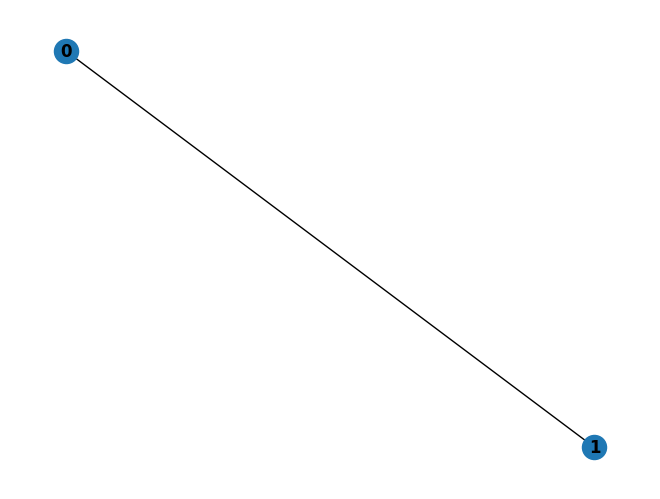

In [65]:

n = 2
p = 1
G = nx.erdos_renyi_graph(n, 1)
for (u,v) in G.edges():
    G[u][v]['weight'] = 1.0

edges = G.edges()
nx.draw(G, with_labels=True, font_weight='bold')
w = np.zeros([n,n])
for (u,v) in G.edges():
    w[u][v] = G[u][v]['weight']
    w[v][u] = G[u][v]['weight']
#print(w)


Classical solution (actual maxcut value) of our graph

In [66]:
# classical solution
sol1 = 0
for b in range(2**n):
    x1 = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    Cut_value1 = 0
    for i in range(n):
        for j in range(n):
            Cut_value1 += w[i][j]*x1[i]*(1-x1[j])
    if sol1 < Cut_value1:
        sol1 = Cut_value1
        xlist1 = x1

print(f"Classical solution: {sol1}")

Classical solution: 1.0


Converting the Classical Maxcut problem function (C(X)) into Cost Hamiltonian $<H_C>$. Note that there is a offset term, which shifts the energy landscape by this offset value. So make sure to add this offset value to the energy calculated at the end to find the actual energy.

In [67]:
prob=Maxcut(w)
qp = prob.to_quadratic_program()
print(qp.prettyprint())
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
print(qubo.prettyprint())

cost_hamiltonian, offset = qubo.to_ising()
print("offset :",offset)
print(cost_hamiltonian)

Problem name: Max-cut

Maximize
  -2*x_0*x_1 + x_0 + x_1

Subject to
  No constraints

  Binary variables (2)
    x_0 x_1

Problem name: Max-cut

Minimize
  2*x_0*x_1 - x_0 - x_1

Subject to
  No constraints

  Binary variables (2)
    x_0 x_1

offset : -0.5
SparsePauliOp(['ZZ'],
              coeffs=[0.5+0.j])


function to calculate the expectation value of $H_C$ w.r.t. the state prepared by the quantum circuit

In [68]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    return cost

Actual errors of the IBM quantum device, ${\bf IBMQX4}$

In [69]:
# Coherence times (in nanoseconds)
T1_fixed = 45e3  # relaxation time (amplitude damping error)
T2_fixed = 20e3  # dephasing time (phase damping error)

# Time taken by different gates
u1 = 0.0  # RZ(gamma) gate (Virtual gate) 
u2 = 60  # Hadamard Gate
u3 = 120  # RX(beta) gate
cx = 720  # CNOT gate (2-qubit gate)

# gate error probability (Depolarizing Error)
err_1q_fixed = 1.5e-3  # 1-qubit gate error
err_2q_fixed = 4e-2  # 2-qubit gate error

Calculating total time taken in the quantum circuit execution

In [70]:
total_execution_time = (p*(len(edges)*cx*2+ n*u3)+ n*u2)                    
t = total_execution_time
print(t)

1800


defining the error probability for amplitude and phase damping

In [71]:
prob = np.linspace(0,0.8,10)
print(prob)

[0.         0.08888889 0.17777778 0.26666667 0.35555556 0.44444444
 0.53333333 0.62222222 0.71111111 0.8       ]


defing zeros array to store different values

In [72]:
err_fom_T1 = np.zeros(len(prob))
err_fom_T2 = np.zeros(len(prob))
fid_T1 = np.zeros(len(prob))
fid_T2 = np.zeros(len(prob))
err_cost_T1 = np.zeros(len(prob))
err_cost_T2 = np.zeros(len(prob))


Initializing parameters usin TQA and preparing quantum circuit for our problem Hamiltonian $H_C$

In [73]:
# Initializing the parameters for our quanutum circuit 
# using Trotterized Quantum Annealing Initialization method.
init_params = np.zeros(2*p)
tt = 0.75
for i in range(0, p, 1):
    init_params[i] = (1.0-i/p)*tt
    init_params[i+p] = (i/p)*tt

# Preparing circuit
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p)
circuit.measure_all()

Ideal Simulator, noiseless

In [74]:
#--------------------------------------------------------------------------------
# Ideal Case
sim_ideal = AerSimulator()
pm5 = generate_preset_pass_manager(optimization_level=3,backend=sim_ideal)
candidate_circuit5 = pm5.run(circuit)

with Session(backend=sim_ideal) as session:  
    estimator = Estimator(mode=session)  
    estimator.options.default_shots = 100000  
    result5 = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit5, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-3,
    )
ideal_cost = result5.fun+offset  # adding offset to get the true expectation value (energy)
print('ideal cost :',ideal_cost)


ideal cost : -0.996210037899621


Finding the superposition state using parameterized quantum circuit by taking optimum parameters from above estimator and COBYLA method

In [75]:

#from qiskit.quantum_info import Statevector, DensityMatrix
# Remove final measurements before creating statevectors
qaoa_circuit_ideal = candidate_circuit5.remove_final_measurements(inplace=False).assign_parameters(result5.x)  # assigning optimum parameters
sim_ideal_state = AerSimulator(method='statevector')
qaoa_circuit_ideal.save_statevector(label='psi_ideal')
result_ideal= sim_ideal_state.run(transpile(qaoa_circuit_ideal, sim_ideal_state)).result()
statevec_ideal = result_ideal.data()['psi_ideal']  # superposition state

calcualting expectation value of $H_C$ using the superposition state prepared above

In [76]:
print("Ideal Expectation Value using superposition state:",statevec_ideal.expectation_value(cost_hamiltonian)+offset)

Ideal Expectation Value using superposition state: (-0.9960444847236071+0j)


Calculating superposition state in Noisy condition, (finite T1 and T2 coherence time), to find the fidelity of $H_C$ for different values of T1 and T2

In [77]:

for kk in range(0, len(prob), 1):
    #----------------------------------------------------------------------
    # T1 error
    p_t1 = prob[kk]
    error_t1 = amplitude_damping_error(p_t1)  # 1-qubit T1 error
    error_t1_cx = amplitude_damping_error(p_t1).tensor(amplitude_damping_error(p_t1))  # 2-qubit T1 error

    # Noise Model
    noise_T1 = NoiseModel()
    noise_T1.add_all_qubit_quantum_error(error_t1, ['u1', 'u2', 'u3'])
    noise_T1.add_all_qubit_quantum_error(error_t1_cx, ['cx'])

    # Noisy quantum Circuit
    sim_T1 = AerSimulator(noise_model=noise_T1)
    pm1 = generate_preset_pass_manager(optimization_level=3,backend=sim_T1)
    candidate_circuit1 = pm1.run(circuit)

    # post processing optimization using calssical optimizer COBYLA
    with Session(backend=sim_T1) as session:  
        estimator = Estimator(mode=session)  
        estimator.options.default_shots = 100000  
        result1 = minimize(
            cost_func_estimator,
            init_params,
            args=(candidate_circuit1, cost_hamiltonian, estimator),
            method="COBYLA",
            tol=1e-3,
        )
    
    T1_cost = result1.fun+offset  # cost value
    err_fom_T1[kk] = T1_cost

    # Remove final measurements before creating statevectors
    qaoa_circuit_noise_T1 = candidate_circuit1.remove_final_measurements(inplace=False).assign_parameters(result1.x)
    sim_noise_T1 = AerSimulator(method='density_matrix', noise_model = noise_T1)
    qaoa_circuit_noise_T1.save_density_matrix(qubits=range(n), label='rho_noise_T1')
    result_noise_T1 = sim_noise_T1.run(transpile(qaoa_circuit_noise_T1, sim_noise_T1)).result()
    rho_noise_T1 = result_noise_T1.data()['rho_noise_T1']  # noisy density matrix
    fid_T1[kk] = np.abs(statevec_ideal.data @ rho_noise_T1.data @ statevec_ideal.data.conj().T)  # Fidelity
    err_cost_T1[kk] = offset+np.real(np.trace(rho_noise_T1 @ cost_hamiltonian.to_matrix()))  # Cost value using noisy density matrix


    #---------------------------------------------------------------------------------
    # T2 error
    p_t2 = prob[kk]
    error_t2 = phase_damping_error(p_t2)
    error_t2_cx = phase_damping_error(p_t2).tensor(phase_damping_error(p_t2))

    noise_T2  = NoiseModel()
    noise_T2.add_all_qubit_quantum_error(error_t2, ['u1', 'u2', 'u3'])
    noise_T2.add_all_qubit_quantum_error(error_t2_cx, ['cx'])

    sim_T2 = AerSimulator(noise_model=noise_T2)
    pm2 = generate_preset_pass_manager(optimization_level=3,backend=sim_T2)
    candidate_circuit2 = pm2.run(circuit)

    with Session(backend=sim_T2) as session:  
        estimator = Estimator(mode=session)  
        estimator.options.default_shots = 100000  
        result2 = minimize(
            cost_func_estimator,
            init_params,
            args=(candidate_circuit2, cost_hamiltonian, estimator),
            method="COBYLA",
            tol=1e-3,
        )
    T2_cost = result2.fun+offset
    err_fom_T2[kk] = T2_cost

    # Remove final measurements before creating statevectors
    qaoa_circuit_noise_T2 = candidate_circuit2.remove_final_measurements(inplace=False).assign_parameters(result2.x)
    sim_noise_T2 = AerSimulator(method='density_matrix', noise_model = noise_T2)
    qaoa_circuit_noise_T2.save_density_matrix(qubits=range(n), label='rho_noise_T2')
    result_noise_T2 = sim_noise_T2.run(transpile(qaoa_circuit_noise_T2, sim_noise_T2)).result()
    rho_noise_T2 = result_noise_T2.data()['rho_noise_T2']
    fid_T2[kk] = np.abs(statevec_ideal.data @ rho_noise_T2.data @ statevec_ideal.data.conj().T)
    err_cost_T2[kk] = offset+np.real(np.trace(rho_noise_T2 @ cost_hamiltonian.to_matrix()))


Plotting fidelity 

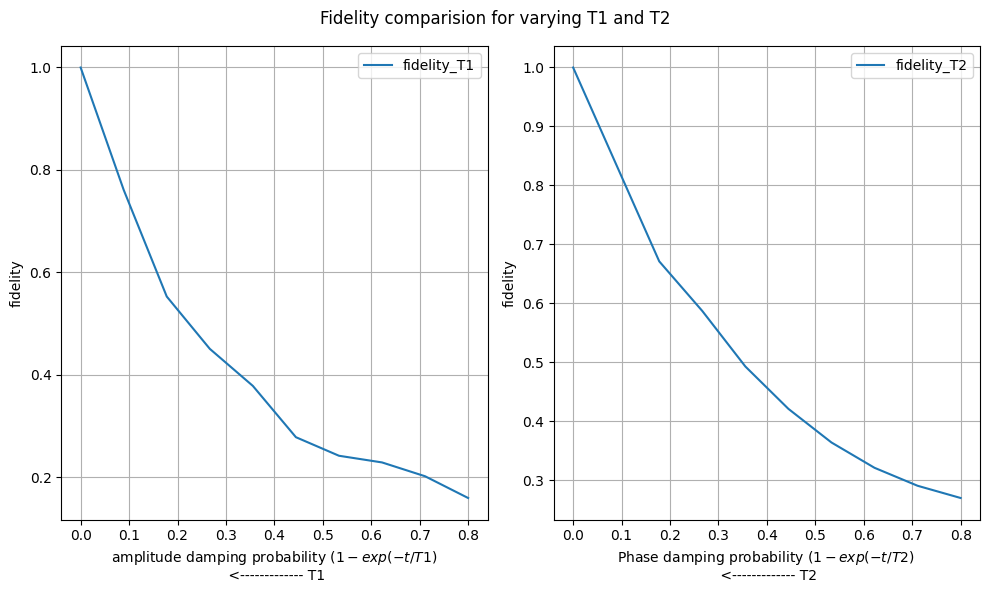

In [78]:
plt.figure(figsize=(10,6))
plt.suptitle('Fidelity comparision for varying T1 and T2')
plt.subplot(1,2,1)
plt.plot(prob, fid_T1, label='fidelity_T1')
plt.xlabel('amplitude damping probability $(1-exp(-t/T1)$ \n <------------- T1')
plt.ylabel('fidelity')
plt.tight_layout()
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(prob, fid_T2, label='fidelity_T2')
plt.xlabel('Phase damping probability $(1-exp(-t/T2)$ \n <------------- T2')
plt.ylabel('fidelity')
plt.tight_layout()
plt.grid()
plt.legend()
plt.show()

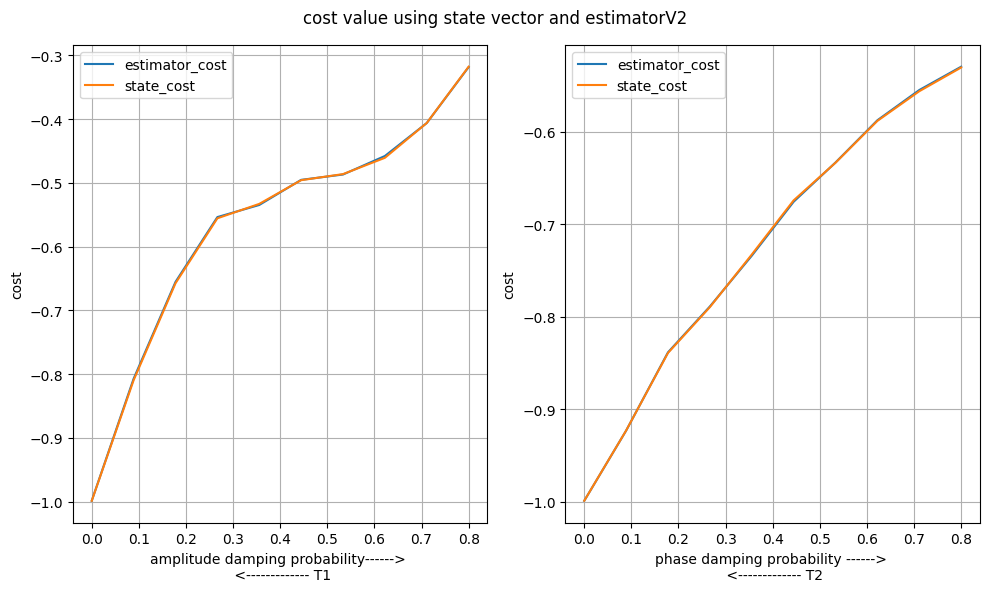

In [79]:
plt.figure(figsize=(10,6))
plt.suptitle("cost value using state vector and estimatorV2")
plt.subplot(1,2,1)
plt.plot(prob, err_fom_T1, label='estimator_cost')
plt.plot(prob, err_cost_T1, label='state_cost')
plt.xlabel('amplitude damping probability------> \n <------------- T1')
plt.ylabel('cost')
plt.tight_layout()
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(prob, err_fom_T2, label='estimator_cost')
plt.plot(prob, err_cost_T2, label='state_cost')
plt.xlabel('phase damping probability ------> \n <------------- T2')
plt.ylabel('cost')
plt.tight_layout()
plt.grid()
plt.legend()

plt.show()

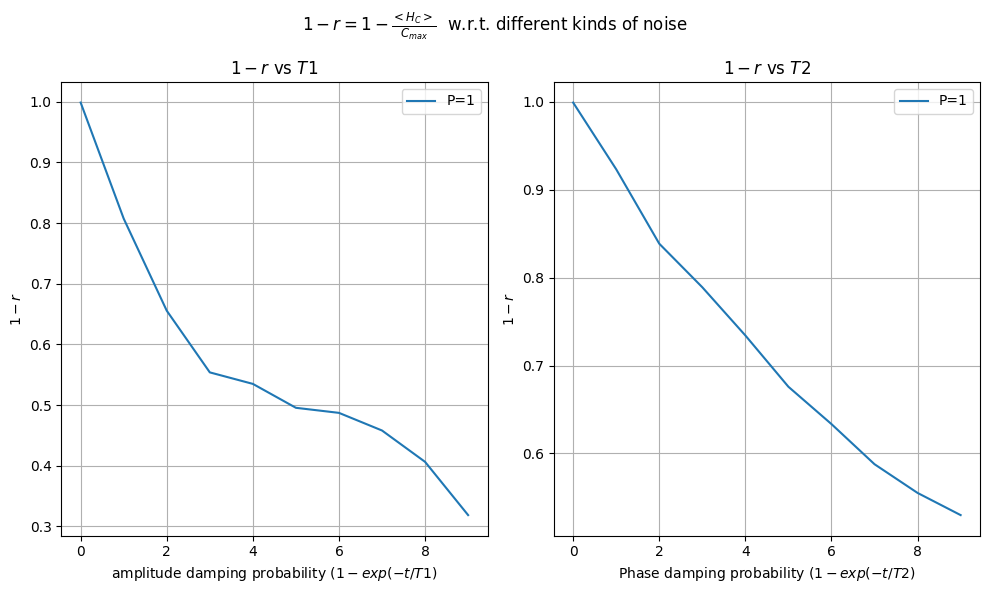

In [80]:
plt.figure(figsize=(10,6))
plt.suptitle('$1-r = 1-\\frac{<H_C>}{C_{max}}$  w.r.t. different kinds of noise')

plt.subplot(1,2,1)
plt.plot(-err_fom_T1, label=f'P={p}')
plt.xlabel('amplitude damping probability $(1-exp(-t/T1)$')
plt.ylabel('$1-r$')
plt.grid()
plt.title('$1-r$ vs $T1$')
plt.tight_layout()
#plt.ylim(0,0.5)
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(-err_fom_T2, label=f'P={p}')
plt.xlabel('Phase damping probability $(1-exp(-t/T2)$')
plt.ylabel('$1-r$')
plt.grid()
plt.title('$1-r$ vs $T2$')
plt.tight_layout()
#plt.ylim(0,0.5)
plt.legend(loc='best')

plt.show()